# TP 2 (17Co2024)
#### Integrantes
- Adassus, Luciano
- De Pedro Mermier, Ignacio
- Cagua, Jonathan

#### Objetivo
Implementar un detector de máximo enfoque sobre un video aplicando técnicas de análisis espectral similar al que utilizan las
cámaras digitales modernas. El video a procesar será: “focus_video.mov”.

In [26]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os
import platform
import subprocess

from scipy.fft import fft2, fftshift
from IPython.display import display, HTML
from ipywidgets import Video

# Ruta del video
video_path = 'video/focus_video.mov'

def open_video(file_path):
    if os.path.exists(file_path):
        if platform.system() == 'Darwin':       # macOS
            subprocess.call(('open', file_path))
        elif platform.system() == 'Windows':    # Windows
            os.startfile(file_path)
        else:                                   # linux variants
            subprocess.call(('xdg-open', file_path))
    else:
        print(f"File not found: {file_path}")

## 1. Se debe implementar un algoritmo que dada una imagen, o región, calcule la métrica propuesta en el paper "Image Sharpness Measure for Blurred Images in Frequency Domain“ y realizar tres experimentos:

##### 1.1 -> Medición sobre todo el frame.
##### 1.2 -> Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.
##### 1.3 -> Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores                arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3)

Para cada experimento se debe presentar :
- Una curva o varias curvas que muestren la evolución de la métrica frame a frame donde se vea claramente cuando el algoritmo detecto el punto
de máximo enfoque.
- Video con la ROI o matriz, graficada en rojo y superpuesta al video original para los frames que no están en foco y verde para los frames
donde se detecta la condición de máximo enfoque.

##### Referencia:
https://www.researchgate.net/publication/275538598_Image_Sharpness_Measure_for_Blurred_Images_in_Frequency_Domain

Se define la función `calculate_frequency_sharpness_metric` para calcular la métrica de nitidez basada en el dominio de frecuencia. Esta métrica (FM) se utiliza para medir el nivel de enfoque de cada frame en el video.

In [27]:
def calculate_frequency_sharpness_metric(image):
    """
    Calcula la métrica de nitidez en el dominio de frecuencia según el paper.
    
    Parámetros:
    - image: numpy.ndarray, imagen en escala de grises.
    
    Retorna:
    - FM: Métrica de nitidez (mayor valor indica mayor nitidez).
    """
    # Calcular la Transformada de Fourier en 2D de la imagen
    f_transform = fft2(image)
    
    # Centrar la Transformada de Fourier
    f_transform_shifted = fftshift(f_transform)
    
    # Obtener el espectro de magnitud
    magnitude_spectrum = np.abs(f_transform_shifted)
    
    # Calcular el valor máximo en el espectro de magnitud
    M = np.max(magnitude_spectrum)
    
    # Establecer el umbral como M/1000
    threshold = M / 1000
    
    # Contar el número de componentes de alta frecuencia
    high_freq_count = np.sum(magnitude_spectrum > threshold)
    
    # Calcular la métrica de nitidez FM
    FM = high_freq_count / (image.shape[0] * image.shape[1])
    
    return FM


Se define una funcion para aplicar unsharp masking para expandir la zona de enfoque y devolver:

In [28]:
def unsharp_masking(image, sigma=1.0, strength=1.5):
    """
    Aplica Unsharp Masking a una imagen para mejorar la nitidez.
    
    Parámetros:
    - image: numpy.ndarray, imagen en escala de grises o en color.
    - sigma: float, desviación estándar para el filtro Gaussiano (determina el nivel de suavizado).
    - strength: float, factor para ajustar la intensidad de la nitidez (nivel de detalle agregado).
    
    Retorna:
    - sharpened: numpy.ndarray, imagen con nitidez mejorada.
    """
    # Aplicar un desenfoque Gaussiano a la imagen
    blurred = cv.GaussianBlur(image, (0, 0), sigma)
    
    # Generar la imagen de alto contraste y combinarla con la original
    sharpened = cv.addWeighted(image, 1.0 + strength, blurred, -strength, 0)
    
    return sharpened

### 1.1 Medición sobre todo el frame

#### Calcular la métrica de enfoque en todo el frame

Se recorre cada frame del video y se calcula la métrica de nitidez en el frame completo usando la función `calculate_frequency_sharpness_metric`. Los resultados se almacenan en la lista `focus_metrics_full_frame`.


In [29]:
# Cargar el video
cap = cv.VideoCapture(video_path)

# Verificar si el video se cargó correctamente
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")

# Variables para almacenar las métricas de enfoque en el frame completo
focus_metrics_full_frame = []
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break    
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Aplicar Unsharp Masking para mejorar la nitidez
    sharpened_frame = unsharp_masking(gray_frame)
    
    full_frame_focus = calculate_frequency_sharpness_metric(sharpened_frame)
    focus_metrics_full_frame.append(full_frame_focus)

cap.set(cv.CAP_PROP_POS_FRAMES, 0)
print("Cálculo de la métrica de enfoque en el frame completo completado.")

# Detectar el frame con el máximo enfoque
max_focus_frame = np.argmax(focus_metrics_full_frame)
max_focus_value = focus_metrics_full_frame[max_focus_frame]

Cálculo de la métrica de enfoque en el frame completo completado.


#### Graficar la evolución de la métrica de enfoque y detectar el máximo:

El punto de máximo enfoque está en el frame 111 con un valor de métrica de enfoque de 0.05



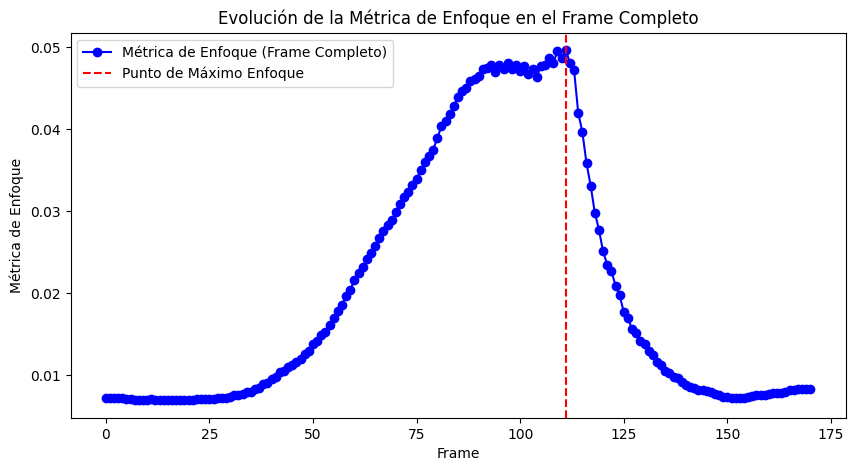

In [30]:
# Detectar el frame con el máximo enfoque
max_focus_frame = np.argmax(focus_metrics_full_frame)
max_focus_value = focus_metrics_full_frame[max_focus_frame]

print(f"El punto de máximo enfoque está en el frame {max_focus_frame} con un valor de métrica de enfoque de {max_focus_value:.2f}")
print()

# Graficar la evolución de la métrica de enfoque
plt.figure(figsize=(10, 5))
plt.plot(focus_metrics_full_frame, label="Métrica de Enfoque (Frame Completo)", color='blue', marker='o')
plt.axvline(x=max_focus_frame, color='red', linestyle='--', label="Punto de Máximo Enfoque")
plt.xlabel("Frame")
plt.ylabel("Métrica de Enfoque")
plt.title("Evolución de la Métrica de Enfoque en el Frame Completo")
plt.legend()
plt.show()

#### Crear video de salida con matriz superpuesta

In [31]:
# Cerrar y reabrir el video de captura
cap.release()
cap = cv.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se pudo reabrir el video.")

output_path = 'video/temp/output_video_exp1.mov'  # Cambiar a .mp4 en caso de problemas con .mov
fourcc = cv.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv.CAP_PROP_FPS))
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Umbral para determinar si un frame está en máximo enfoque
max_focus_value = max(focus_metrics_full_frame)
threshold_focus = 0.9 * max_focus_value

# Parámetros para la matriz de enfoque 5x5
grid_rows, grid_cols = 5, 5
cell_width = frame_width // grid_cols
cell_height = frame_height // grid_rows

# Procesar cada frame para superponer la matriz de enfoque
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # Aplicar Unsharp Masking al frame
    sharpened_frame = unsharp_masking(frame)
    
    # Determinar el color de la matriz según la métrica de enfoque del frame
    if focus_metrics_full_frame[i] >= threshold_focus:
        color = (0, 255, 0)  # Verde para frames en máximo enfoque
    else:
        color = (0, 0, 255)  # Rojo para frames fuera de enfoque

    # Superponer la matriz de enfoque sobre el frame
    for row in range(grid_rows):
        for col in range(grid_cols):
            top_left = (col * cell_width, row * cell_height)
            bottom_right = ((col + 1) * cell_width, (row + 1) * cell_height)
            cv.rectangle(sharpened_frame, top_left, bottom_right, color, 2)
    
    # Escribir el frame en el video de salida
    out.write(sharpened_frame)

# Liberar los recursos
cap.release()
out.release()

print("Video de salida generado con éxito en el path:", "../" + output_path)
open_video(output_path)

Video de salida generado con éxito en el path: ../video/temp/output_video_exp1.mov


### 1.2 Medición sobre una ROI ubicada en el centro del frame. Area de la ROI = 5 o 10% del area total del frame.

#### Configurar parámetros para la ROI:

In [32]:
# Cargar el video
cap = cv.VideoCapture(video_path)

# Verificar si el video se cargó correctamente
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")

# Variables para almacenar las métricas de enfoque en la ROI central
focus_metrics_roi = []
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

# Parámetro de área deseada para la ROI (10% o 5% del área total del frame)
desired_area_ratio = 0.10  # Cambia a 0.05 si prefieres un 5%

# Calcular las dimensiones de la ROI basadas en el área deseada
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
total_area = frame_height * frame_width
roi_area = total_area * desired_area_ratio
roi_side = int(np.sqrt(roi_area))  # Suponiendo una ROI cuadrada

# Calcular la posición de la ROI en el centro del frame
roi_x = (frame_width - roi_side) // 2
roi_y = (frame_height - roi_side) // 2

#### Calcular la métrica de enfoque en la ROI central y guardar los resultados
Aquí calculamos la métrica de enfoque en la ROI central para cada frame y guardamos los resultados en focus_metrics_roi:

In [33]:
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
    
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Definir la ROI central
    roi = gray_frame[roi_y:roi_y + roi_side, roi_x:roi_x + roi_side]
    
    # Aplicar el unsharp mask en la ROI
    sharpened_roi = unsharp_masking(roi)
    
    # Calcular la métrica de enfoque en la ROI procesada
    roi_focus = calculate_frequency_sharpness_metric(sharpened_roi)
    focus_metrics_roi.append(roi_focus)

cap.set(cv.CAP_PROP_POS_FRAMES, 0)
print("Cálculo de la métrica de enfoque en la ROI central completado.")

Cálculo de la métrica de enfoque en la ROI central completado.


#### Graficar la evolución de la métrica de enfoque en la ROI y detectar el máximo
Este código genera la gráfica de la métrica de enfoque para cada frame y destaca el frame con el valor de enfoque máximo en la ROI:

El punto de máximo enfoque en la ROI está en el frame 91 con un valor de métrica de enfoque de 0.61



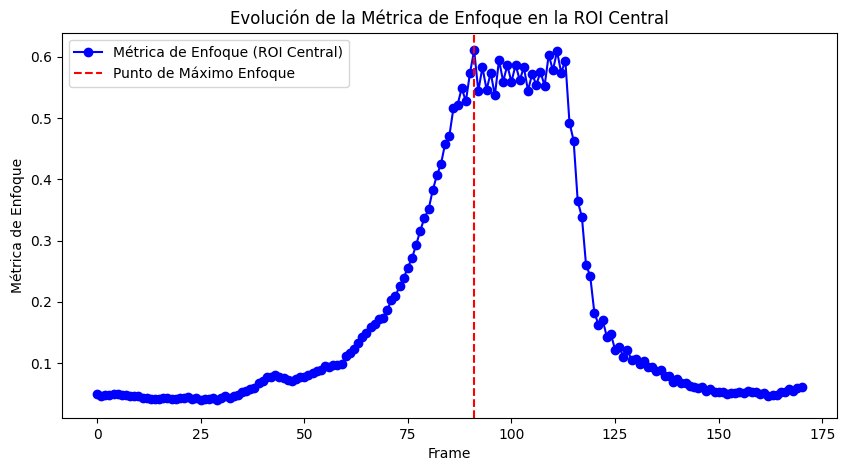

In [34]:
# Detectar el frame con el máximo enfoque en la ROI
max_focus_frame = np.argmax(focus_metrics_roi)
max_focus_value = focus_metrics_roi[max_focus_frame]

# Imprimir el frame de máximo enfoque y su valor
print(f"El punto de máximo enfoque en la ROI está en el frame {max_focus_frame} con un valor de métrica de enfoque de {max_focus_value:.2f}")
print()

# Graficar la evolución de la métrica de enfoque en la ROI
plt.figure(figsize=(10, 5))
plt.plot(focus_metrics_roi, label="Métrica de Enfoque (ROI Central)", color='blue', marker='o')
plt.axvline(x=max_focus_frame, color='red', linestyle='--', label="Punto de Máximo Enfoque")
plt.xlabel("Frame")
plt.ylabel("Métrica de Enfoque")
plt.title("Evolución de la Métrica de Enfoque en la ROI Central")
plt.legend()
plt.show()

####  Crear video de salida con indicador de ROI central
Este código crea un video de salida en el que la ROI central está destacada en verde si el frame cumple con la condición de máximo enfoque y en rojo si no lo hace:

In [35]:
# Cerrar y reabrir el video de captura
cap.release()
cap = cv.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se pudo reabrir el video.")

# Configuración del archivo de salida
output_path = 'video/temp/output_video_exp2.mov'
fourcc = cv.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv.CAP_PROP_FPS))
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Parámetro para definir la matriz de NxM celdas en la ROI central
n_rows, n_cols = 7, 7  # Cambia estos valores para una matriz de diferente tamaño, como 5x5 o 3x3

# Porcentaje de área total para la ROI
##desired_area_ratio = 0.05

# Calcular el tamaño y la posición de la ROI
total_area = frame_height * frame_width
roi_area = total_area * desired_area_ratio
roi_side = int(np.sqrt(roi_area))  # Suponiendo una ROI cuadrada
roi_x = (frame_width - roi_side) // 2
roi_y = (frame_height - roi_side) // 2

# Dimensiones de cada celda en la matriz
cell_width = roi_side // n_cols
cell_height = roi_side // n_rows

# Umbral para determinar si un frame está en máximo enfoque, con un umbral menos estricto
max_focus_value = max(focus_metrics_roi)
threshold_focus = 0.8 * max_focus_value  # Reducido a 80% del valor máximo

# Parámetros para mantener el verde durante múltiples frames consecutivos
consecutive_focus_frames = 0
required_consecutive_frames = 2  # Ajustado para cambiar a verde más fácilmente

# Procesar cada frame y agregar la matriz de enfoque al video de salida
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break
        
    # Convertir el frame a escala de grises para el cálculo de nitidez
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    
    # Comprobar si la métrica de enfoque supera el umbral
    if focus_metrics_roi[i] >= threshold_focus:
        consecutive_focus_frames += 1
        # print(f"Frame {i}: En enfoque - aumentando conteo consecutivo a {consecutive_focus_frames}")
    else:
        consecutive_focus_frames = 0
        # print(f"Frame {i}: Fuera de enfoque - reiniciando conteo consecutivo")

    # Si la métrica está en enfoque durante los frames consecutivos requeridos, mostrar en verde
    if consecutive_focus_frames >= required_consecutive_frames:
        color = (0, 255, 127)  # Verde fuerte para celdas en enfoque
    else:
        color = (0, 0, 255)  # Rojo para celdas fuera de enfoque

    # Dibujar cada celda en la matriz
    for row in range(n_rows):
        for col in range(n_cols):
            # Calcular las coordenadas de cada celda en la ROI
            top_left_x = roi_x + col * cell_width
            top_left_y = roi_y + row * cell_height
            bottom_right_x = top_left_x + cell_width
            bottom_right_y = top_left_y + cell_height           
           
            # Extraer y aplicar unsharp mask a cada celda
            cell = gray_frame[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
            sharpened_cell = unsharp_masking(cell)
            
            # Calcular la métrica de enfoque en la celda nitidez mejorada (opcional)
            cell_focus_metric = calculate_frequency_sharpness_metric(sharpened_cell)
            
            # Dibujar el rectángulo de la celda en el frame original a color
            cv.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, 2)

    # Escribir el frame en el video de salida
    out.write(frame)

# Liberar recursos
cap.release()
out.release()

print("Video de salida generado con éxito en el path:", "../" + output_path)
open_video(output_path)

Video de salida generado con éxito en el path: ../video/temp/output_video_exp2.mov


### 1.3 Medición sobre una matriz de enfoque compuesta por un arreglo de NxM elementos rectangulares equiespaciados. N y M son valores arbitrarios, probar con varios valores 3x3, 7x5, etc … (al menos 3).

#### Generar las curvas de evolución de la métrica de enfoque
El siguiente código calcula la métrica de nitidez para cada celda en diferentes configuraciones de matriz (3x3, 5x5, 7x5) y luego grafica la evolución de la métrica a lo largo de los frames:

Matriz (3, 3): Punto de máximo enfoque en el frame 111 con un valor de 0.22
Matriz (5, 5): Punto de máximo enfoque en el frame 91 con un valor de 0.31
Matriz (7, 5): Punto de máximo enfoque en el frame 91 con un valor de 0.35



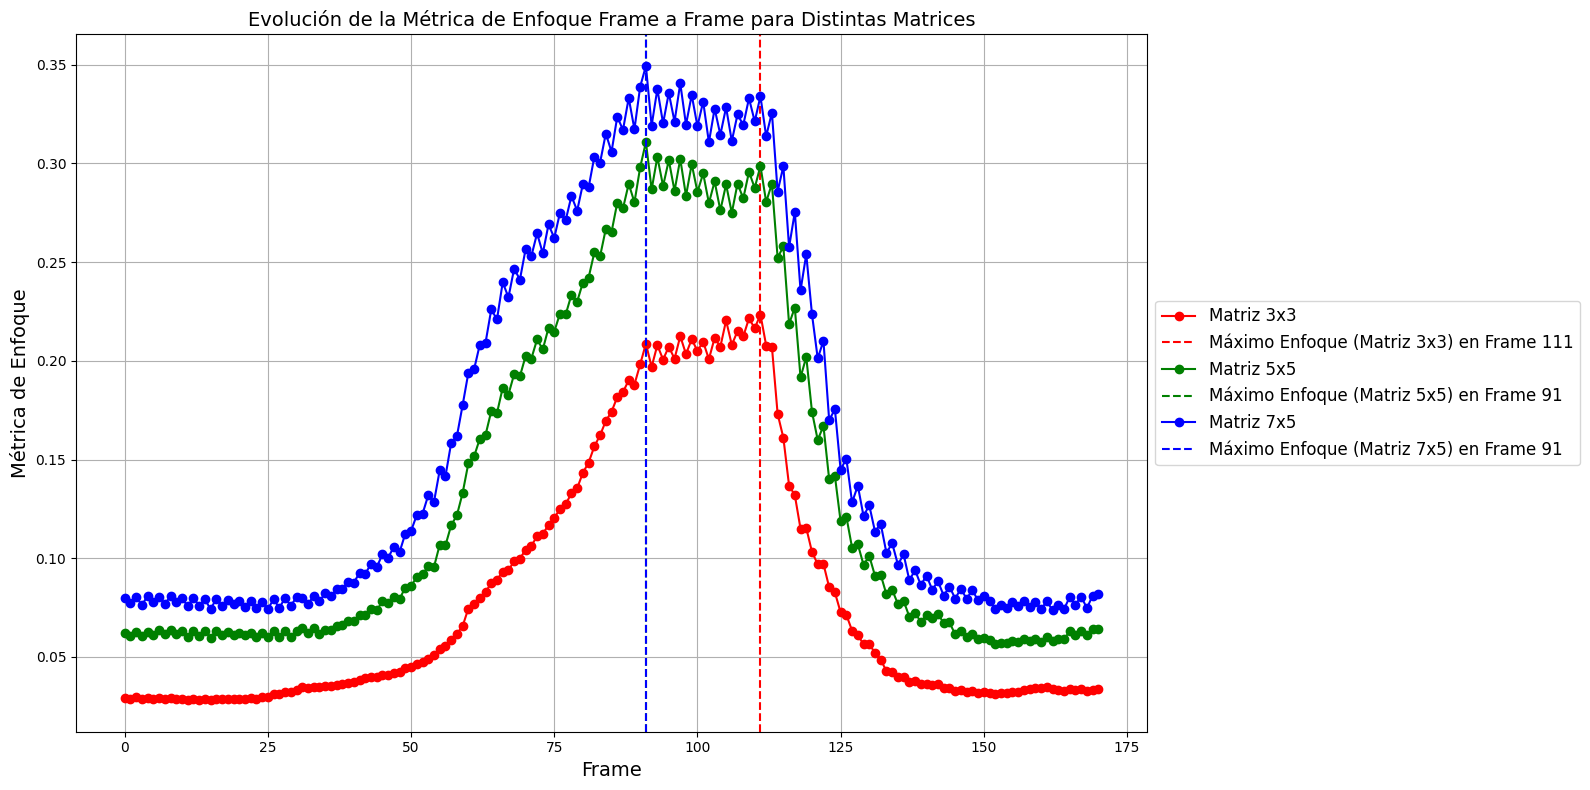

In [36]:
# Cargar el video
cap = cv.VideoCapture(video_path)

# Verificar si el video se cargó correctamente
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")

# Diccionario para almacenar las métricas de enfoque por matriz
focus_metrics_matrices = {}

# Definir las configuraciones de matrices a probar
matrix_sizes = [(3, 3), (5, 5), (7, 5)]
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

# Inicializar el diccionario para cada configuración de matriz
for matrix_size in matrix_sizes:
    focus_metrics_matrices[matrix_size] = []

# Colores para las líneas punteadas de cada matriz
colors = ['red', 'green', 'blue']

# Iterar sobre cada tamaño de matriz
plt.figure(figsize=(16, 8))  # Ajustar a una figura más alargada

for idx, matrix_size in enumerate(matrix_sizes):
    n_rows, n_cols = matrix_size
    cell_width = frame_width // n_cols
    cell_height = frame_height // n_rows
    
    cap.set(cv.CAP_PROP_POS_FRAMES, 0)  # Reiniciar el video
    frame_focus_values = []

    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        cell_focus_values = []
        
        for row in range(n_rows):
            for col in range(n_cols):
                # Extraer cada celda de la matriz
                top_left_x = col * cell_width
                top_left_y = row * cell_height
                bottom_right_x = top_left_x + cell_width
                bottom_right_y = top_left_y + cell_height
                cell = frame[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

                # Convertir la celda a escala de grises
                gray_cell = cv.cvtColor(cell, cv.COLOR_BGR2GRAY)
                
                # Aplicar Unsharp Mask a la celda
                sharpened_cell = unsharp_masking(gray_cell)
                
                # Calcular la métrica de enfoque usando la celda con unsharp_mask aplicado
                focus_metric = calculate_frequency_sharpness_metric(sharpened_cell)
                cell_focus_values.append(focus_metric)                
        
        # Guardar el valor promedio de enfoque del frame actual para esta configuración de matriz
        focus_metrics_matrices[matrix_size].append(np.mean(cell_focus_values))
    
    # Generar curva para esta configuración de matriz
    max_focus_frame = np.argmax(focus_metrics_matrices[matrix_size])
    max_focus_value = focus_metrics_matrices[matrix_size][max_focus_frame]
    
    # Graficar la curva de evolución de la métrica de enfoque para la configuración actual
    plt.plot(focus_metrics_matrices[matrix_size], label=f'Matriz {n_rows}x{n_cols}', marker='o', color=colors[idx])
    # Marcar el punto de máximo enfoque en la curva con una línea punteada de color específico
    plt.axvline(x=max_focus_frame, color=colors[idx], linestyle='--', label=f'Máximo Enfoque (Matriz {n_rows}x{n_cols}) en Frame {max_focus_frame}')
    
    # Imprimir resultados del punto de máximo enfoque en consola
    print(f"Matriz {matrix_size}: Punto de máximo enfoque en el frame {max_focus_frame} con un valor de {max_focus_value:.2f}")

print()
# Mostrar todas las curvas juntas
plt.xlabel('Frame', fontsize=14)
plt.ylabel('Métrica de Enfoque', fontsize=14)
plt.title('Evolución de la Métrica de Enfoque Frame a Frame para Distintas Matrices', fontsize=14)

plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

#### Crear el video de salida con la matriz coloreada
Generaremos un video donde cada celda de la matriz se colorea en verde cuando la métrica de enfoque de esa celda alcanza el máximo enfoque y en rojo en caso contrario:

In [37]:
# Cerrar y reabrir el video de captura
cap.release()
cap = cv.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se pudo reabrir el video.")

output_path = 'video/temp/output_video_exp3.mov'
fourcc = cv.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv.CAP_PROP_FPS))
out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Iterar sobre cada tamaño de matriz para generar el video
for matrix_size in matrix_sizes:
    n_rows, n_cols = matrix_size
    cell_width = frame_width // n_cols
    cell_height = frame_height // n_rows
    
    cap.set(cv.CAP_PROP_POS_FRAMES, 0)  # Reiniciar el video

    # Determinar el umbral de enfoque para colorear en verde
    max_focus_values = focus_metrics_matrices[matrix_size]
    threshold_focus = 0.9 * max(max_focus_values)
    
    for i in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break
        
        # Obtener los valores de enfoque para cada celda en este frame
        cell_focus_values = []
        
        for row in range(n_rows):
            for col in range(n_cols):
                # Definir límites de la celda
                top_left_x = col * cell_width
                top_left_y = row * cell_height
                bottom_right_x = top_left_x + cell_width
                bottom_right_y = top_left_y + cell_height
                cell = frame[top_left_y:bottom_right_y, top_left_x:bottom_right_x]
                
                # Convertir la celda a escala de grises y aplicar el Unsharp Masking
                gray_cell = cv.cvtColor(cell, cv.COLOR_BGR2GRAY)
                sharpened_cell = unsharp_masking(gray_cell)
                
                # Calcular métrica de enfoque en la celda con Unsharp Masking aplicado
                focus_metric = calculate_frequency_sharpness_metric(sharpened_cell)
                
                # Determinar el color de la celda en función del enfoque
                color = (0, 255, 0) if focus_metric >= threshold_focus else (0, 0, 255)
                
                # Dibujar la celda en el frame
                cv.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, 2)

        # Escribir el frame en el video de salida
        out.write(frame)

cap.release()
out.release()

print("Video de salida generado con éxito en el path:", "../" + output_path)
open_video(output_path)

Video de salida generado con éxito en el path: ../video/temp/output_video_exp3.mov


## 2. Cambiar la métrica de enfoque eligiendo uno de los algoritmos explicados en el apéndice de: Analysis of focus measure operators in shapefrom focus.

##### Referencia:
https://www.researchgate.net/publication/234073157_Analysis_of_focus_measure_operators_in_shape-from-focus

En base a la referencia se va a implementar la métrica de enfoque de Tenengrad, que se basa en el análisis de gradientes.

### Métrica de Enfoque de Tenengrad

La **métrica de enfoque de Tenengrad** es un método que evalúa la nitidez de una imagen al medir la magnitud de los gradientes de intensidad. Este método es útil para detectar áreas de alto contraste, como bordes o detalles finos, ya que los bordes nítidos producen valores de gradiente elevados, indicando que la imagen está bien enfocada. Es comúnmente utilizada en cámaras digitales modernas para medir la nitidez de una escena.

#### Fórmula de Tenengrad

La métrica de Tenengrad se basa en el cálculo de los gradientes de intensidad en las direcciones \( x \) y \( y \). Para cada píxel de la imagen, se calcula la magnitud del gradiente usando operadores de Sobel para obtener los gradientes en las direcciones horizontal y vertical, respectivamente. La fórmula de Tenengrad es la siguiente:

$$
f = \sum_{(i, j)} \left( G_x(i, j)^2 + G_y(i, j)^2 \right)
$$

#### Pasos para el Cálculo de la Métrica de Tenengrad
$$ 
  G_x(i, j) = \text{Gradiente horizontal del píxel}
$$

$$
G_y(i, j) = \text{Gradiente vertical del píxel}
$$

1. **Calcular los gradientes**: Usar operadores de Sobel para calcular los gradientes en las direcciones \( x \) y \( y \), respectivamente.
2. **Calcular la magnitud del gradiente**: Para cada píxel, se calcula la magnitud del gradiente como:

   $$
   G_x(i, j)^2 + G_y(i, j)^2
   $$

3. **Sumar la magnitud de gradientes**: La métrica de Tenengrad \( f \) se obtiene sumando la magnitud de gradientes en todos los píxeles de la región seleccionada, lo cual representa el nivel de enfoque o nitidez de esa región.

Un valor alto de la métrica de Tenengrad indica una imagen más nítida, ya que los bordes y detalles están mejor definidos.

Este enfoque es efectivo para medir el enfoque en regiones con alta frecuencia de detalles y es utilizado en análisis de imágenes para tareas de detección de enfoque en escenas.



In [38]:
# Definir la funcion de Tenengrad
def tenengrad_focus_metric(image):
    """
    Calcula la métrica de enfoque de Tenengrad en una imagen en escala de grises.
    
    Parámetros:
    - image: imagen en escala de grises.
    
    Retorna:
    - Métrica de enfoque de Tenengrad normalizada.
    """
    # Calcular gradientes en dirección X y Y
    Gx = cv.Sobel(image, cv.CV_64F, 1, 0, ksize=3)
    Gy = cv.Sobel(image, cv.CV_64F, 0, 1, ksize=3)
    # Calcular la métrica de enfoque normalizada
    return np.sum(Gx**2 + Gy**2) / (image.shape[0] * image.shape[1] * 1000)  # Dividido por 1000 para escalar

#### Calcular la Curva de Enfoque en cada Frame
Esta celda carga el video, aplica la métrica de enfoque de Tenengrad a cada frame en una ROI central, y almacena los valores de enfoque.

Punto de máximo enfoque: Frame 111 con un valor de métrica de enfoque de 19.19



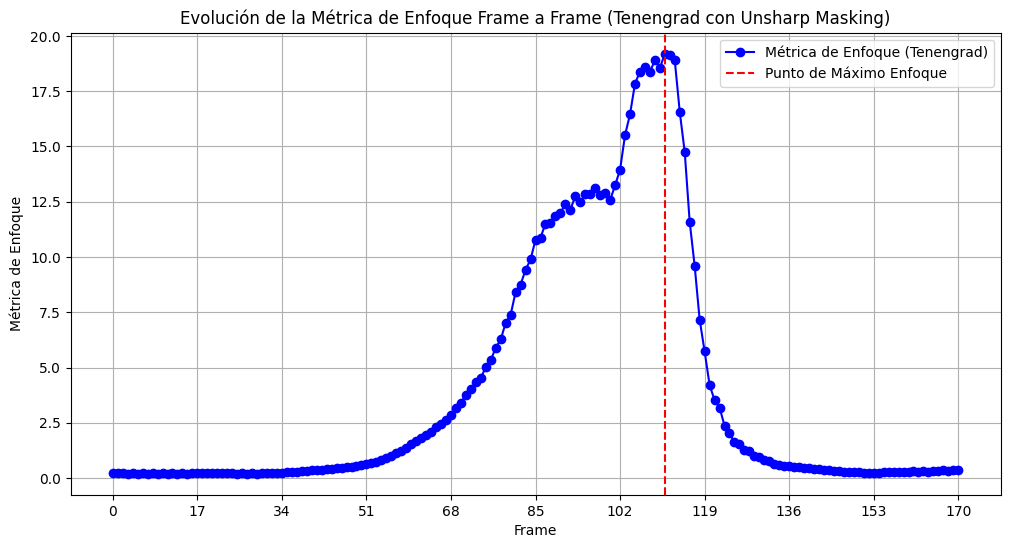

In [39]:
# Parámetros del video
cap = cv.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se pudo abrir el video.")

# Configuración de la ROI central
frame_width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
desired_area_ratio = 0.1  # ROI de 10% del área total
roi_side = int(np.sqrt(desired_area_ratio * frame_width * frame_height))
roi_x = (frame_width - roi_side) // 2
roi_y = (frame_height - roi_side) // 2

# Lista para almacenar las métricas de enfoque de cada frame
focus_metrics = []

# Procesar cada frame y calcular la métrica de enfoque de Tenengrad en la ROI
frame_count = int(cap.get(cv.CAP_PROP_FRAME_COUNT))
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir a escala de grises
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # Aplicar Unsharp Masking
    enhanced_frame = unsharp_masking(gray_frame)

    # Extraer la ROI
    roi = enhanced_frame[roi_y:roi_y + roi_side, roi_x:roi_x + roi_side]

    # Calcular la métrica de enfoque de Tenengrad en la ROI
    focus_metric = tenengrad_focus_metric(roi)
    focus_metrics.append(focus_metric)

# Liberar el video una vez procesado
cap.release()

# Encontrar y mostrar el punto de máximo enfoque
max_focus_frame = np.argmax(focus_metrics)
max_focus_value = focus_metrics[max_focus_frame]
print(f"Punto de máximo enfoque: Frame {max_focus_frame} con un valor de métrica de enfoque de {max_focus_value:.2f}")
print()

# Graficar la evolución de la métrica de enfoque
plt.figure(figsize=(12, 6))
plt.plot(focus_metrics, label="Métrica de Enfoque (Tenengrad)", color="blue", marker="o")
plt.axvline(x=max_focus_frame, color="red", linestyle="--", label="Punto de Máximo Enfoque")
plt.xlabel("Frame")
plt.ylabel("Métrica de Enfoque")
plt.title("Evolución de la Métrica de Enfoque Frame a Frame (Tenengrad con Unsharp Masking)")
plt.legend()
plt.grid()
plt.xticks(range(0, frame_count, max(1, frame_count // 10)))
plt.show()

#### Generación del Video de Salida con la ROI Central Superpuesta
Esta celda genera el video de salida mostrando la ROI en verde para frames de máximo enfoque y en rojo para los demás:

In [40]:
# Cerrar y reabrir el video de captura
cap.release()
cap = cv.VideoCapture(video_path)
if not cap.isOpened():
    print("Error: No se pudo reabrir el video.")

output_path = 'video/temp/output_video_tenengrad.mov'

fourcc = cv.VideoWriter_fourcc(*'mp4v')
fps = int(cap.get(cv.CAP_PROP_FPS))
out = cv.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Parámetros de la matriz de enfoque
n_rows, n_cols = 7, 7  # Puedes ajustar el tamaño de la matriz aquí
cell_width = frame_width // n_cols
cell_height = frame_height // n_rows

# Umbral para determinar si una celda está en máximo enfoque
threshold_focus = 0.7 * max(focus_metrics)

# Procesar cada frame y aplicar la técnica de Tenengrad junto con Unsharp Masking
for i in range(frame_count):
    ret, frame = cap.read()
    if not ret:
        break

    # Convertir el frame a escala de grises y aplicar Unsharp Masking
    gray_frame = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    enhanced_frame = unsharp_masking(gray_frame)

    # Procesar cada celda en la matriz
    for row in range(n_rows):
        for col in range(n_cols):
            # Definir los límites de la celda
            top_left_x = col * cell_width
            top_left_y = row * cell_height
            bottom_right_x = top_left_x + cell_width
            bottom_right_y = top_left_y + cell_height
            
            # Extraer la celda de la imagen mejorada
            cell = enhanced_frame[top_left_y:bottom_right_y, top_left_x:bottom_right_x]

            # Calcular la métrica de Tenengrad en la celda
            cell_focus_metric = tenengrad_focus_metric(cell)

            # Determinar el color de la celda en función de la métrica de enfoque
            color = (0, 255, 0) if cell_focus_metric >= threshold_focus else (0, 0, 255)

            # Dibujar la celda en el frame original
            cv.rectangle(frame, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, 2)

    # Escribir el frame en el video de salida
    out.write(frame)

# Liberar los recursos
cap.release()
out.release()

print("Video de salida generado con éxito en el path:", "../" + output_path)
open_video(output_path)

Video de salida generado con éxito en el path: ../video/temp/output_video_tenengrad.mov
